
# OpenCV dnn 패키지를 이용, faster_RCNN 기반 구현(Object Detection)
* Tensorflow 에서 Pretrained 된 모델 파일을 이용해 OpenCV dnn 패키지를 이용하여 로드, 이미지 및 영상에 대한 Object Detection 수행

## 라이브러리 불러오기

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## 입력 이미지 확인(Object Detection 할 이미지)

image shape : (3447, 5170, 3)


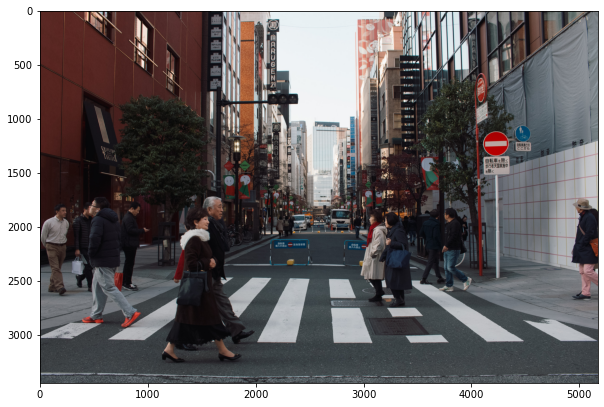

In [8]:
img = cv2.imread('../../../data/image/crossroads2.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f'image shape : {img_rgb.shape}')
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.show()

## pretrained model, config 파일 활용
[OpenCV:TensorFlow-Object-Detection-API](https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API) 에서 사용가능한 모델의 weights와 config 파일 다운로드 가능, 

Faster_RCNN 기반, backbone은 ResNet50을 사용한 model(pretrained with coco-datasets)의 weights 를 활용하기 위해 아래 필요한 사항을 다운로드 및 압축해제를 진행

1. pretrained model의 weight 다운로드
2. opencv 용 config file 다운로드

mkdir : 폴더 만들기, mv : 폴더 이름 바꾸기, rm : 삭제, tar -xvf : 파일 압축 풀기, curl : url 파일 다운로드 (-o 으로 파일 이름 변경)

### pretrained model의 weight 다운로드
* mac 은 console 창에 아래 코드로 pretrained 된 weights 다운로드
```python
curl http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz -o pretrained.tar.gz 
```
* 다운로드 후 압축을 풀어줌
```
tar -xvf pretrained.tar.gz
```
* 압축이 해제된 폴더를 가보게 되면 아래 파일들이 존재함   
    
```
<console>
drwxr-xr-x  9 coding_min  staff        288  2  2  2018 .
drwxr-xr-x  3 coding_min  staff         96  4 10 12:55 ..
-rw-r--r--  1 coding_min  staff         77  2  2  2018 checkpoint
-rw-r--r--  1 coding_min  staff  120549957  2  2  2018 frozen_inference_graph.pb
-rw-r--r--  1 coding_min  staff  176914228  2  2  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 coding_min  staff      14460  2  2  2018 model.ckpt.index
-rw-r--r--  1 coding_min  staff    5675175  2  2  2018 model.ckpt.meta
-rw-r--r--  1 coding_min  staff       3240  2  2  2018 pipeline.config
drwxr-xr-x  4 coding_min  staff        128  2  2  2018 saved_model
```
`model.ckpt` 로 시작하는 파일들은 model 이 학습(epoch 돌면서)하면서 생성된 checkpoint들이고, 이파일들을 기반으로해서 inference 용으로 변환된 파일이 `frozen_inference_graph.pb` 파일임.  

### opencv 용 config file 다운로드 
*  `frozen_inference_graph.pb` 파일이 있는 디렉토리에 다음 pbtxt 파일을 [다운로드](https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt)
```
curl https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt -o faster_rcnn_resnet50_coco_2018_01_28.pbtxt
```
* 디렉토리 확인

```
<console>
drwxr-xr-x  10 coding_min  staff        320  4 10 13:04 .
drwxr-xr-x   3 coding_min  staff         96  4 10 12:55 ..
-rw-r--r--   1 coding_min  staff         77  2  2  2018 checkpoint
-rw-r--r--   1 coding_min  staff      90893  4 10 13:04 faster_rcnn_resnet50_coco_2018_01_28.pbtxt
-rw-r--r--   1 coding_min  staff  120549957  2  2  2018 frozen_inference_graph.pb
-rw-r--r--   1 coding_min  staff  176914228  2  2  2018 model.ckpt.data-00000-of-00001
-rw-r--r--   1 coding_min  staff      14460  2  2  2018 model.ckpt.index
-rw-r--r--   1 coding_min  staff    5675175  2  2  2018 model.ckpt.meta
-rw-r--r--   1 coding_min  staff       3240  2  2  2018 pipeline.config
drwxr-xr-x   4 coding_min  staff        128  2  2  2018 saved_model
```
`faster_rcnn_resnet50_coco_2018_01_28.pbtxt` 파일은 opencv용 config 파일로 tensorflow 에서 trained 된 모델에 대한 정보를 Opencv 용 config 파일로 저장된 파일임.

##  OpenCV inference model 생성
앞서 다운로드 받았던 pretrained inference(frozen_inference_graph.pb) + config(pbtxt) 을 `cv2.readNetFromTensorflow()` 의 인잣값으로 입력

**dnn 모듈에서 readNetFromTensorflow 으로 tensorflow inference 모델 생성**

In [4]:
inference_graph = 'pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb'
config_pbtxt = 'pretrained/faster_rcnn_resnet50_coco_2018_01_28/graph.pbtxt'

# opencv 로 네트워크 모델을 load
cv_net = cv2.dnn.readNetFromTensorflow(inference_graph, config_pbtxt)

**coco class_id 매핑** 

In [6]:
# 0 ~ 90 (Tensoflow Faster RCNN, Mask RCNN 모델)
labels_to_names_0 = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

## 이미지 preprocessing 후 Network 에 입력 및 object Detecion 수행

cvOut shape :  (1, 1, 100, 7)
0번, class : person, score:0.999
1번, class : person, score:0.999
2번, class : person, score:0.998
3번, class : person, score:0.998
4번, class : person, score:0.998
5번, class : person, score:0.995
6번, class : person, score:0.991
7번, class : person, score:0.988
8번, class : person, score:0.984
9번, class : person, score:0.984
10번, class : person, score:0.983
11번, class : person, score:0.950
12번, class : person, score:0.939
13번, class : person, score:0.925
14번, class : person, score:0.826
15번, class : person, score:0.820
16번, class : person, score:0.807


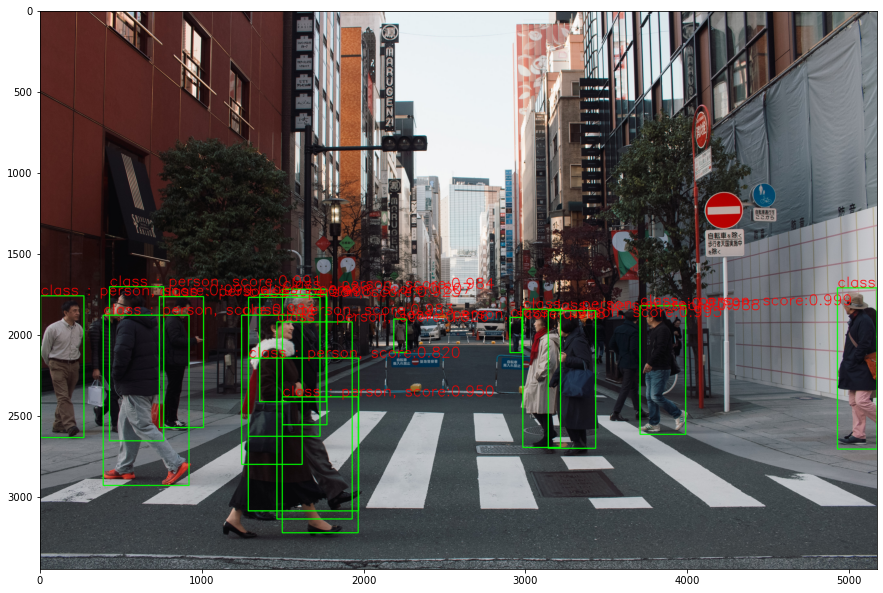

In [40]:
# 원본 이미지가 Faster RCNN 기반 네트워크로 입력되면서 Resize 가 됨.
rows = img.shape[0]
cols = img.shape[1]
 
# cv_net 에 이미지 입력, RB 색상 swap, crop 적용 x
cv_net.setInput(cv2.dnn.blobFromImage(img, swapRB=True, crop=False))

# Object Detecion 수행 결과 cvOut 로 반환
cvOut = cv_net.forward()
print('cvOut shape : ', cvOut.shape)

# img
draw_img = img.copy()

# bounding box의 색상, caption 색상 지정
green_color = (0, 255, 0)
red_color = (0, 0, 255)

# bounding box & class 정보로 이미지 위에 rectangle, caption 그리기
for index, detection in enumerate(cvOut[0, 0, :, :]):
    class_id = int(detection[1])
    score = float(detection[2])
    if score > 0.8:
        left, top = int(detection[3] * cols), int(detection[4] * rows)
        right, bottom = int(detection[5] * cols), int(detection[6] * rows)
        
        # bounding box 시각화
        cv2.rectangle(draw_img, (left, top), (right, bottom), color=green_color, thickness=5)
        # class 및 score 시각화
        caption = 'class : {}, score:{:.3f}'.format(labels_to_names_0[class_id], score)
        cv2.putText(draw_img, caption, (left, top-5), cv2.FONT_HERSHEY_SIMPLEX, 3, color=red_color, thickness=3)
        print(f'{index}번, {caption}')

rgb_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 15))
plt.imshow(rgb_img)

In [39]:
first_det = cvOut[:, :, 0, :][0][0]
print(f'\n<첫번째 detection 정보 보기> \n 클래스: {first_det[1]} \n score: {first_det[2]}, \n 좌상단 좌표 : ({first_det[3]}, {first_det[4]}),\n 우하단 좌표 : ({first_det[5]}, {first_det[6]})')


<첫번째 detection 정보 보기> 
 클래스: 0.0 
 score: 0.9994827508926392, 
 좌상단 좌표 : (0.7169700264930725, 0.5289474725723267),
 우하단 좌표 : (0.7714523673057556, 0.7590091228485107)
